In [17]:
from qiskit import QuantumRegister, QuantumCircuit 
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import StatePreparation, QFT

import sys
sys.path.append('../../funcs')
from spectral1d import QuantumReflection
from piecewise_bivarpoly import BivarPoly

import numpy as np
from numpy.polynomial import polynomial as poly
import matplotlib.pyplot as plt
from math import gamma
from scipy.special import kv

In [18]:
# random white noise 
def forcing(x, sig=1, rand = False):
    """Forcing function"""
    n = len(x)
    nd_1d = int(np.sqrt(n))

    forcing_function = np.zeros(n)
    if rand == False:
        forcing_function[int(n/2) + int(np.sqrt(n) / 2)] = 1.
    else: 
        for i in range(nd_1d):
            for j in range(nd_1d):
                if(i == 0   or j == 0):
                    forcing_function[(nd_1d* i) + j] = 0. # make sure it's zero at x = 0 and y = 0
                else:
                    forcing_function[(nd_1d* i) + j] = np.random.normal(0, sig**2)

    return forcing_function

@np.vectorize
def freqs_sqr(k):
    """Return the square of the relabeled frequencies."""
    return (np.pi * k)**2


def square_inverse_coeffs(k0_left, k1_lower, k0_right, k1_upper, deg, beta, kappa):
    """Fit a polynomial of degree deg to 1/k^2 on a domain of [0, N-1]x[0, N-1]"""
    """Return the value of the polynomial coefficients"""

    # interpolation points in 1D
    intp_pts_1d_k0 = np.linspace(k0_left, k0_right, deg + 1)
    intp_pts_1d_k1 = np.linspace(k1_lower, k1_upper, deg + 1)

    # interpolation points in 2D and the Vandermonde matrix
    kx_intp, ky_intp = np.meshgrid(intp_pts_1d_k0, intp_pts_1d_k1)
    van_mat = poly.polyvander2d(kx_intp.flatten(), ky_intp.flatten(), deg=(deg, deg))

    # compute the inverse square of the frequencies
    k_sqr = 1 / (kappa**2 + (freqs_sqr(kx_intp) + freqs_sqr(ky_intp))) ** (2*beta)

    # conditioning of the vandermonde matrix
    scale = np.abs(van_mat).sum(axis=0)
    van_mat /= scale

    poly_coeffs, resids, rank, s = np.linalg.lstsq(van_mat, k_sqr.flatten(), rcond=None)
    poly_coeffs = (poly_coeffs.T / scale).T

    return poly_coeffs.reshape([deg + 1, deg + 1])


/var/folders/tn/bpv7203512s5w_qmpd5848z80000gn/T/ipykernel_12364/1876992304.py:62: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft = QFT(num_qubits=nq_x+nb_x,inverse=False).to_gate()


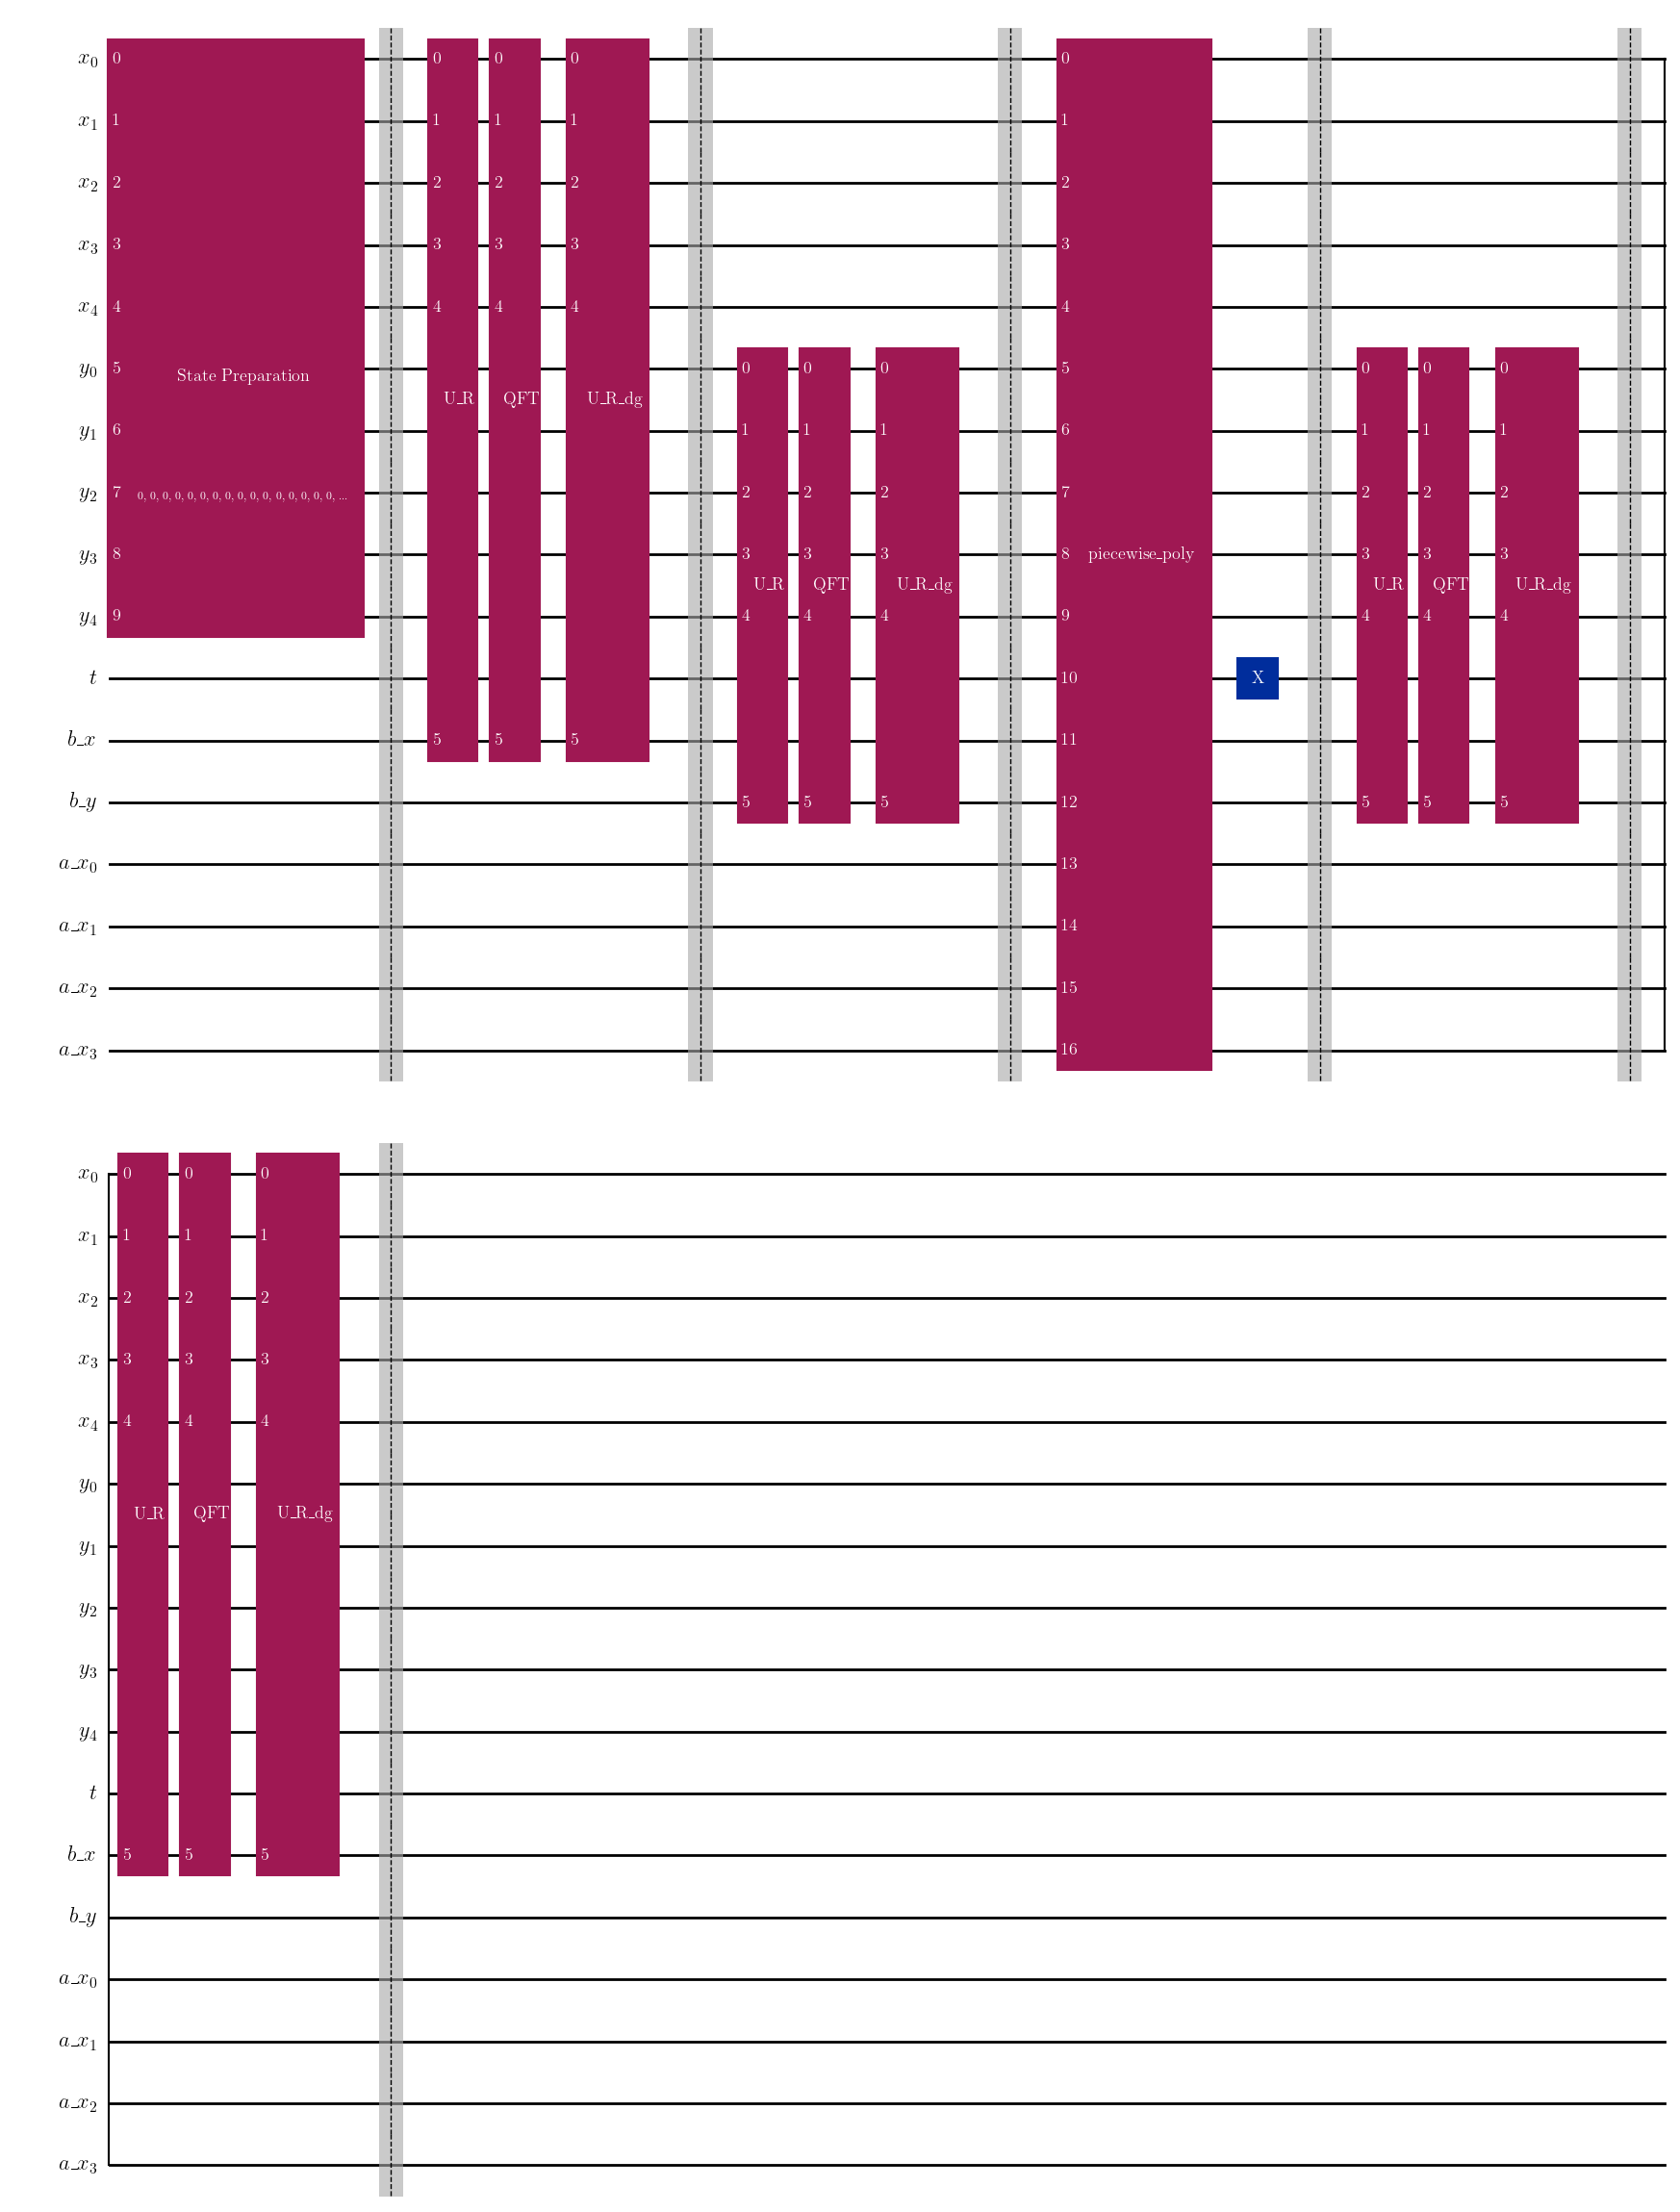

In [19]:
# number of qubits for discretisation
# x axis
nq_x = 5 # state qubits for x discretisation 
nb_x = 1
na_x = nq_x - 1

# y axis
nq_y = nq_x # state qubits for y discretisation 
nb_y = 1
na_y = nq_y - 1

nt   = 1           # polynomial target qubits

# for convenience
nq = nq_x + nq_y   # 2D state qubits
nb = nb_x + nb_y   # extension qubits 
na = na_x + na_y   # ancilla qubits

qcx = QuantumRegister(nq_x, 'x')
qbx = QuantumRegister(nb_x, 'b_x')
qax = QuantumRegister(na_x, 'a_x') 
qcy = QuantumRegister(nq_y, 'y')
qby = QuantumRegister(nb_y, 'b_y')
qay = QuantumRegister(na_y, 'a_y')
qt  = QuantumRegister(nt, 't')
qc  = QuantumCircuit(qcx, qcy, qt, qbx, qby, qax)

# domain definition in 1D
nd_1d = 2**(nq_x)         # number of elements in 1D
nd_2d = 2**(nq)           # number of elements in 2D
l  = 1.
x0 = 0.
x1 = x0 + l

# 2D grid generation
xi = np.linspace(x0, x1, nd_1d+1)
xi = xi[:nd_1d]
xv, yv = np.meshgrid(xi, xi)

# spde problem definition
nu    = 1
dim   = 2
sigma = 1
ell   = 0.1
beta  = (nu/2) + (dim /4)
kappa = np.sqrt(2 * nu) / ell
tau   = np.sqrt(gamma(nu) / (sigma**2 * gamma(nu + dim/2) * (4. * np.pi)**(dim/2) * (kappa ** (2*nu))))

fi = np.zeros(nd_2d)
fi = forcing(np.reshape(xv, [nd_1d**2, 1]), sig=sigma, rand=True)
norm = np.linalg.norm(fi)

# state preparation
qc.append(StatePreparation(fi/norm), list(range(nq)))
qc.barrier()

# Reflection unitary U_R
qr = QuantumReflection(nq_x, 1)
qr_gate = qr.build()

# QFT
qft = QFT(num_qubits=nq_x+nb_x,inverse=False).to_gate()

# inverse of U_R
qref_inv = qr.inverse()
qr_inv_gate = qref_inv.to_gate(label="U_R_dg")

# Spectral transformation for x direction
qlist_spectral_x = list(range(nq_x)) + [nq + nt]

qc.append(qr_gate, qlist_spectral_x)
qc.append(qft, qargs=qlist_spectral_x)
qc.append(qr_inv_gate, qlist_spectral_x)
qc.barrier()

# Spectral transformation for y direction
qlist_spectral_y = list(range(nq_x, nq)) + [nq + nt + nb_x]

qc.append(qr_gate, qlist_spectral_y)
qc.append(qft, qargs=qlist_spectral_y)
qc.append(qr_inv_gate, qlist_spectral_y)
qc.barrier()

### Solve the SPDE in the Fourier space

# Multivariate polynomial encoder
# eps                   = 1e-6  # for num_qubits_half < 5
eps                   = 5e-6  # for num_qubits_half >= 5
max_univariate_degree = 4

num_patches           = 2
limit                 = int(nd_1d / 2)
breakpoints           = [[0, 16], [0, 16]]

# Initialise a 4D array to stores all coefficient matrices for the piecewise polynomial
coeffs_matrix = np.zeros((
    num_patches,
    num_patches,
    max_univariate_degree + 1,
    max_univariate_degree + 1,
))

coeffs_matrix[0, 0, :, :] = square_inverse_coeffs(
    1,
    1,
    breakpoints[0][1],
    breakpoints[1][1],
    max_univariate_degree,
    beta,
    kappa,
)
coeffs_matrix[0, 1, :, :] = square_inverse_coeffs(
    1,
    breakpoints[0][1],
    breakpoints[1][1],
    2**nq_x - 1,
    max_univariate_degree,
    beta,
    kappa,
)
coeffs_matrix[1, 0, :, :] = square_inverse_coeffs(
    breakpoints[0][1],
    1,
    2**nq_x - 1,
    breakpoints[1][1],
    max_univariate_degree,
    beta,
    kappa,
)
coeffs_matrix[1, 1, :, :] = square_inverse_coeffs(
    breakpoints[0][1],
    breakpoints[1][1],
    2**nq_x - 1,
    2**nq_x - 1,
    max_univariate_degree,
    beta,
    kappa,
)

qc.append(
    BivarPoly( nq_x, coeffs_matrix, max_univariate_degree, breakpoints, eps).build(), range(3*nq_x+2)
)

qc.x(nq)
qc.barrier()

# Spectral transformation for y direction
qc.append(qr_gate, qlist_spectral_y)
qc.append(qft, qargs=qlist_spectral_y)
qc.append(qr_inv_gate, qlist_spectral_y)
qc.barrier()

# Spectral transformation for x direction
qc.append(qr_gate, qlist_spectral_x)
qc.append(qft, qargs=qlist_spectral_x)
qc.append(qr_inv_gate, qlist_spectral_x)
qc.barrier()

qc.draw("mpl")


In [20]:
state = Statevector(qc).data.real

In [21]:
fac = (1/tau * nd_2d)
out = norm*state
result = fac*1/eps*out[0: nd_2d]

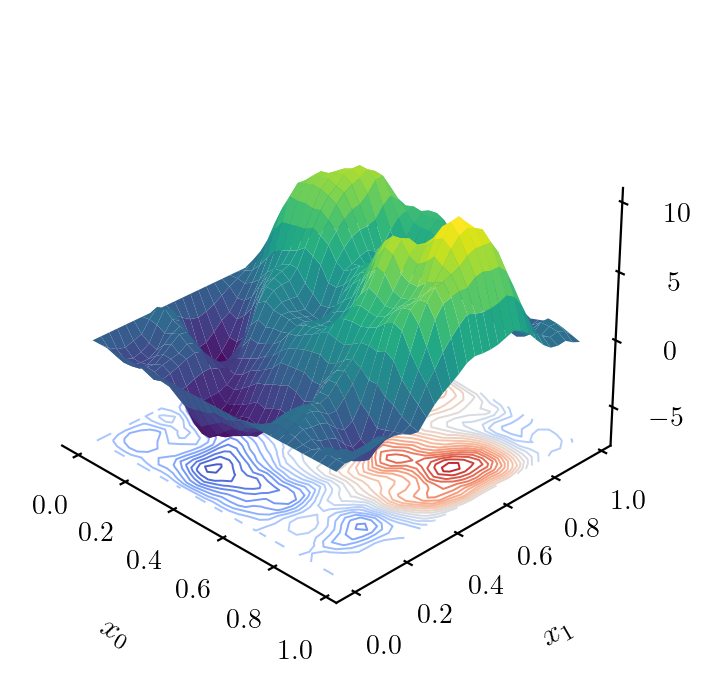

In [ ]:
fig = plt.figure(figsize=(8, 4), dpi=200)
plt.rc('text', usetex=True)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})

# Create 3D axis
ax1 = fig.add_subplot(111, projection='3d')

# Plot surface with improved colormap and antialiasing
res = np.sqrt(2)*nd_1d * result[0:nd_2d].reshape((nd_1d, nd_1d))
ax1.plot_surface(xv, yv, res, cmap='viridis', edgecolor='none', linewidth=0.3, antialiased=True)
ax1.contour(xv, yv, res, zdir='z', offset=1.5*np.min(res), cmap='coolwarm', levels=30, linewidths=0.7)

# Labels and title
ax1.set_zlim(1.5*np.min(res), np.max(res))
ax1.set_xlabel(r'$x_0$', fontsize=12, labelpad=10)
ax1.set_ylabel(r'$x_1$', fontsize=12, labelpad=10)
# ax1.set_title('Solution Field (Quantum)', fontsize=12, pad=10)

ax1.grid(False)
ax1.xaxis.pane.set_visible(False)
ax1.yaxis.pane.set_visible(False)
ax1.zaxis.pane.set_visible(False)

# Adjust camera angle for better visualization
ax1.view_init(elev=30, azim=-45)

plt.savefig('matern-field-surf-4.pdf',bbox_inches = "tight")

import h5py
with h5py.File('matern-4.h5', 'w') as f:
    f.create_dataset('x', data=xv)
    f.create_dataset('y', data=yv)
    f.create_dataset('u', data=res)